In [1]:
import pandas as pd
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from datetime import datetime
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, pairwise_distances
from sklearn.metrics import confusion_matrix
from collections import OrderedDict
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from pythainlp.tokenize import word_tokenize


In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

## Cleaning data

In [3]:
def data_cleaning(df):
    # Removing \n from date field
    for i in range(len(df['date'])):
        if df['date'][i][0] == '\n':
            df['date'][i] = df['date'][i][1:]

    # Making yelpJoinDate Format Uniform
    df['yelpJoinDate'] = df['yelpJoinDate'].apply(
        lambda x: datetime.strftime(datetime.strptime(x, '%B %Y'), '01/%m/%Y'))

    # Pre-processing Text Reviews
    # Remove Symbols
    df['reviewContent'] = df['reviewContent'].apply(
        lambda x: ''.join(char for char in str(x) if char not in '!"#$&\'()*.:;<=>?@[\\]^_`{|}~'))

    return df

## Feature Engineering

In [4]:
def feature_engineering(df):
    mnr_df1 = df[['reviewerID', 'date']].copy()
    mnr_df2 = mnr_df1.groupby(by=['date', 'reviewerID']).size().reset_index(name='reviewPerDay')
    mnr_df2['scaledReviewPerDay'] = mnr_df2['reviewPerDay'] / mnr_df2['reviewPerDay'].max()
    mnr_df2.drop(columns=['reviewPerDay'], inplace=True)
    df = df.merge(mnr_df2, on=['reviewerID', 'date'], how='inner')

    # Review Length
    df['reviewsLength'] = df['reviewContent'].apply(
        lambda x: len(word_tokenize(x, engine="newmm")))

    # Review Deviation
    df['reviewsDeviation'] = abs(df['rating'] - df['restaurantRating']) / 4

    # Maximum cosine similarity
    review_data = df

    res = OrderedDict()

    # Iterate over data and create groups of reviewers
    for row in review_data.iterrows():
        if row[1].reviewerID in res:
            res[row[1].reviewerID].append(row[1].reviewContent)
        else:
            res[row[1].reviewerID] = [row[1].reviewContent]

    individual_reviewer = [{'reviewerID': k, 'reviewContent': v} for k, v in res.items()]
    df2 = dict()
    df2['reviewerID'] = pd.Series([])
    df2['maximumContentSimilarity'] = pd.Series([])
    vector = TfidfVectorizer(min_df=0)
    count = -1
    for reviewer_data in individual_reviewer:
        count = count + 1
        # Handle Null/single review gracefully -24-Apr-2019
        try:
            tfidf = vector.fit_transform(reviewer_data['reviewContent'])
        except:
            pass
        cosine = 1 - pairwise_distances(tfidf, metric='cosine')

        np.fill_diagonal(cosine, -np.inf)
        max = cosine.max()

        # To handle reviewier with just 1 review
        if max == -np.inf:
            max = 0
        df2['reviewerID'][count] = reviewer_data['reviewerID']
        df2['maximumContentSimilarity'][count] = max

    df3 = pd.DataFrame(df2, columns=['reviewerID', 'maximumContentSimilarity'])

    # left outer join on original datamatrix and cosine dataframe -24-Apr-2019
    df = pd.merge(review_data, df3, on="reviewerID", how="left")

    df.drop(index=np.where(pd.isnull(df))[0], axis=0, inplace=True)
    return df

## Sampling

In [5]:
def under_sampling(df):
    print("Under-Sampling Data")

    sample_size = len(df[(df['flagged'] == 'Y')])

    authentic_reviews_df = df[df['flagged'] == 'N']
    fake_reviews_df = df[df['flagged'] == 'Y']

    authentic_reviews_us_df = authentic_reviews_df.sample(sample_size)
    under_sampled_df = pd.concat([authentic_reviews_us_df, fake_reviews_df], axis=0)

    print("Under-Sampling Complete")
    return under_sampled_df

In [6]:
def over_sampling(df):
    print("Over-Sampling Data")

    sample_size = len(df[(df['flagged'] == 'N')])

    authentic_reviews_df = df[df['flagged'] == 'N']
    fake_reviews_df = df[df['flagged'] == 'Y']

    fake_reviews_os_df = fake_reviews_df.sample(sample_size, replace=True)
    over_sampled_df = pd.concat([authentic_reviews_df, fake_reviews_os_df], axis=0)

    print("Over-Sampling Complete")
    return over_sampled_df

## Plot

In [7]:
def plot_confusion_matrix(y_true, y_pred, classes, title=None, cmap=plt.cm.Blues):
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes,
           yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()

    return plt

## Learning

In [8]:
def supervised_learning(df, model, algorithm):
    df = df.copy()
    print("Training "+algorithm+" Model")
    labels = df['flagged']

    df.drop(['reviewID', 'reviewerID', 'restaurantID', 'date', 'name', 'location', 'yelpJoinDate', 'flagged',
             'reviewContent', 'restaurantRating'], axis=1, inplace=True)

    train_data, test_data, train_label, test_label = train_test_split(df, labels, test_size=0.25, random_state=42)

    # param_grid = {
    #     'n_estimators': [10, 500],
    #     'max_features': ['auto', 'sqrt', 'log2'],
    #     'max_depth': [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14],
    #     'criterion': ['gini', 'entropy']
    # }
    # grid_clf_acc = GridSearchCV(estimator=model, param_grid=param_grid, cv=5)
    #
    # grid_clf_acc.fit(train_data, train_label)

    model.fit(train_data, train_label)
    predicted_labels = model.predict(test_data)

    # print('Best Params : ', grid_clf_acc.best_params_)
    print(algorithm + ' Model Results')
    print('--' * 20)
    print('Accuracy Score : ' + str(accuracy_score(test_label, predicted_labels)))
    print('Precision Score : ' + str(precision_score(test_label, predicted_labels, pos_label="Y")))
    print('Recall Score : ' + str(recall_score(test_label, predicted_labels, pos_label="Y")))
    print('F1 Score : ' + str(f1_score(test_label, predicted_labels, pos_label="Y")))
    print('Confusion Matrix : \n' + str(confusion_matrix(test_label, predicted_labels)))
    plot_confusion_matrix(test_label, predicted_labels, classes=['N', 'Y'],
                          title=algorithm + ' Confusion Matrix').show()

    return test_label, predicted_labels, model

In [9]:
def semi_supervised_learning(df, model, algorithm, threshold=0.8, iterations=40):
    df = df.copy()
    print("Training "+algorithm+" Model")
    labels = df['flagged']

    # df.drop(['reviewID', 'reviewerID', 'restaurantID', 'date', 'name', 'location', 'yelpJoinDate', 'flagged', 'restaurantRating'], axis=1, inplace=True)
    df.drop(['reviewID', 'reviewerID', 'restaurantID', 'date', 'name', 'location', 'yelpJoinDate',
             'flagged', 'restaurantRating', 'usefulCount', 'coolCount', 'funnyCount',
             'complimentCount', 'tipCount', 'fanCount'], axis=1, inplace=True)

    train_data, test_data, train_label, test_label = train_test_split(df, labels, test_size=0.25, random_state=42)

    test_review_content = test_data['reviewContent']
    train_data.drop(['reviewContent'], axis=1, inplace=True)
    test_data.drop(['reviewContent'], axis=1, inplace=True)
    
    test_data_copy = test_data.copy()
    test_label_copy = test_label.copy()

    all_labeled = False

    current_iteration = 0

    # param_grid = {
    #     'n_estimators': [10, 500],
    #     'max_features': ['auto', 'sqrt', 'log2'],
    #     'max_depth': [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14],
    #     'criterion': ['gini', 'entropy']
    # }
    # grid_clf_acc = GridSearchCV(estimator=model, param_grid=param_grid, cv=5)
    #
    # grid_clf_acc.fit(train_data, train_label)

    pbar = tqdm(total=iterations)

    while not all_labeled and (current_iteration < iterations):
        # print("Before train data length : ", len(train_data))
        # print("Before test data length : ", len(test_data))
        current_iteration += 1
        model.fit(train_data, train_label)

        probabilities = model.predict_proba(test_data)
        pseudo_labels = model.predict(test_data)

        indices = np.argwhere(probabilities > threshold)

        # print("rows above threshold : ", len(indices))
        for item in indices:
            train_data.loc[test_data.index[item[0]]] = test_data.iloc[item[0]]
            train_label.loc[test_data.index[item[0]]] = pseudo_labels[item[0]]
        test_data.drop(test_data.index[indices[:, 0]], inplace=True)
        test_label.drop(test_label.index[indices[:, 0]], inplace=True)
        # print("After train data length : ", len(train_data))
        # print("After test data length : ", len(test_data))
        print("--" * 20)

        if len(test_data) == 0:
            print("Exiting loop")
            all_labeled = True
        pbar.update(1)
    pbar.close()
    predicted_labels = model.predict(test_data_copy)

    # print('Best Params : ', grid_clf_acc.best_params_)
    print(algorithm + ' Model Results')
    print('--' * 20)
    print('Accuracy Score : ' + str(accuracy_score(test_label_copy, predicted_labels)))
    print('Precision Score : ' + str(precision_score(test_label_copy, predicted_labels, pos_label="Y")))
    print('Recall Score : ' + str(recall_score(test_label_copy, predicted_labels, pos_label="Y")))
    print('F1 Score : ' + str(f1_score(test_label_copy, predicted_labels, pos_label="Y")))
    print('Confusion Matrix : \n' + str(confusion_matrix(test_label_copy, predicted_labels)))
    plot_confusion_matrix(test_label_copy, predicted_labels, classes=['N', 'Y'],
                          title=algorithm + ' Confusion Matrix').show()

    results = test_data_copy.copy()
    results['reviewContent'] = test_review_content
    results['flagged'] = test_label_copy
    results['predicted'] = predicted_labels

    return model, results
                          

## Make train dataset

In [10]:
# df = pd.read_csv('../Data/raw_thai_df.csv', index_col=0)
# df = data_cleaning(df)
# df = feature_engineering(df)
# df.to_csv('../Data/thai_df.csv', index=False)


In [11]:
df = pd.read_csv('../Data/thai_df.csv')

In [12]:
# under_sampled_df = under_sampling(df)
# under_sampled_df.to_csv('../Data/thai_under_sampled_df.csv', index=False)
under_sampled_df = pd.read_csv('../Data/thai_under_sampled_df.csv')

In [13]:
# over_sampled_df = over_sampling(df)
# over_sampled_df.to_csv('../Data/thai_over_sampled_df.csv', index=False)
over_sampled_df = pd.read_csv('../Data/thai_over_sampled_df.csv')

# Dataframe EDA

In [14]:
# df.head(5)

In [15]:
# df.columns

In [16]:
train_df = df.drop(['reviewID', 'reviewerID', 'restaurantID', 'date', 'name', 'location', 'yelpJoinDate', 'flagged', 'reviewContent', 'restaurantRating', 'usefulCount', 'coolCount', 'funnyCount',
                     'complimentCount', 'tipCount', 'fanCount'], axis=1)
train_df.to_csv('../Data/thai_train_df.csv', index=False)

In [17]:
train_df.columns

Index(['rating', 'reviewUsefulCount', 'friendCount', 'reviewCount',
       'firstCount', 'scaledReviewPerDay', 'reviewsLength', 'reviewsDeviation',
       'maximumContentSimilarity'],
      dtype='object')

### Train DF Columns
- rating = comment rating **<span style="color:CornflowerBlue">(raw review file)</span>**
- reviewUsefulCount = number of user's review useful count raw **<span style="color:CornflowerBlue">(count form raw review file)</span>** 
- friendCount = number of user's friend raw **<span style="color:CornflowerBlue">(join form user file)</span>** 
- reviewCount = number of user's review count raw **<span style="color:CornflowerBlue">(join form user file)</span>** 
- firstCount = number of user's first comment raw **<span style="color:CornflowerBlue">(count form raw review file)</span>** 
- usefulCount = number of comment's useful count raw **<span style="color:CornflowerBlue">(raw review file)</span>** 
- coolCount = number of comment's cool count raw **<span style="color:CornflowerBlue">(raw review file)</span>** 
- funnyCount = number of comment's funny count raw **<span style="color:CornflowerBlue">(raw review file)</span>** 
- complimentCount = review's compliment count raw **<span style="color:CornflowerBlue">(join form tip file)</span>** 
- tipCount = user's tip count raw **<span style="color:CornflowerBlue">(join form tip file)</span>** 
- fanCount = number of user's fan raw **<span style="color:CornflowerBlue">(join form user file)</span>** 
- scaledReviewPerDay = scaled review per day raw **<span style="color:CornflowerBlue">(calculate from raw review file)</span>** 
- reviewsLength = review length raw **<span style="color:CornflowerBlue">(calculate from raw review file)</span>** 
- reviewsDeviation = store rating - user rating raw **<span style="color:CornflowerBlue">(calculate form businees and reviews file)</span>**
- maximumContentSimilarity = maximun content similarity raw **<span style="color:CornflowerBlue">(calculate from raw review file)</span>** 

In [18]:
# import warnings
# warnings.filterwarnings('ignore')

In [19]:
# %matplotlib inline
# from autoviz.AutoViz_Class import AutoViz_Class
# autoviz = AutoViz_Class().AutoViz('../Data/thai_train_df.csv')

## Model

In [20]:
rf = RandomForestClassifier(random_state=42, criterion='entropy', max_depth=14, max_features='auto',
                            n_estimators=500)
nb = GaussianNB()

Training Random Forest Model


  7%|▋         | 1/15 [00:23<05:27, 23.37s/it]

----------------------------------------


 13%|█▎        | 2/15 [00:32<03:11, 14.72s/it]

----------------------------------------


 20%|██        | 3/15 [00:40<02:21, 11.80s/it]

----------------------------------------


 27%|██▋       | 4/15 [00:48<01:54, 10.41s/it]

----------------------------------------


 33%|███▎      | 5/15 [00:56<01:36,  9.65s/it]

----------------------------------------


 40%|████      | 6/15 [01:05<01:22,  9.16s/it]

----------------------------------------


 47%|████▋     | 7/15 [01:13<01:11,  8.90s/it]

----------------------------------------


 53%|█████▎    | 8/15 [01:21<01:00,  8.67s/it]

----------------------------------------


 60%|██████    | 9/15 [01:29<00:51,  8.53s/it]

----------------------------------------


 67%|██████▋   | 10/15 [01:38<00:42,  8.40s/it]

----------------------------------------


 73%|███████▎  | 11/15 [01:46<00:33,  8.34s/it]

----------------------------------------


 80%|████████  | 12/15 [01:54<00:24,  8.27s/it]

----------------------------------------


 87%|████████▋ | 13/15 [02:02<00:16,  8.25s/it]

----------------------------------------


 93%|█████████▎| 14/15 [02:10<00:08,  8.22s/it]

----------------------------------------


100%|██████████| 15/15 [02:18<00:00,  9.26s/it]

----------------------------------------


Random Forest Model Results
----------------------------------------
Accuracy Score : 0.8883776161496215
Precision Score : 0.7614617940199335
Recall Score : 0.7446393762183235
F1 Score : 0.7529566360052562
Confusion Matrix : 
[[4839  359]
 [ 393 1146]]


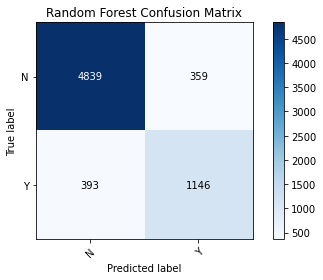

Training Naive Bayes Model


 13%|█▎        | 2/15 [00:19<01:43,  7.98s/it]

----------------------------------------
----------------------------------------
----------------------------------------


 53%|█████▎    | 8/15 [00:19<00:08,  1.15s/it]

----------------------------------------
----------------------------------------
----------------------------------------
----------------------------------------
----------------------------------------
----------------------------------------
----------------------------------------


100%|██████████| 15/15 [00:19<00:00,  1.32s/it]

----------------------------------------
----------------------------------------
----------------------------------------
----------------------------------------
----------------------------------------
Naive Bayes Model Results
----------------------------------------
Accuracy Score : 0.6931868784325368
Precision Score : 0.4260089686098655
Recall Score : 0.9876543209876543


F1 Score : 0.5952614059134521
Confusion Matrix : 
[[3150 2048]
 [  19 1520]]


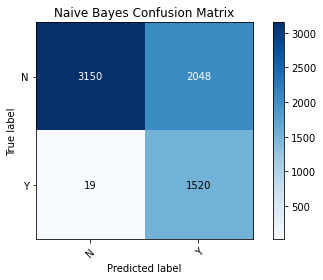

(GaussianNB(),
        rating  reviewUsefulCount  friendCount  reviewCount  firstCount  \
 196         3                  2            8           24           0   
 6354        2                  1            6           97           0   
 3860        4                  0           12           74           4   
 8999        4                  0           15            2           0   
 99          5                  3           33          257           0   
 ...       ...                ...          ...          ...         ...   
 11839       2                  0            0            3           0   
 15827       4                  0            0           38           4   
 5473        4                  0           62          326           2   
 15180       5                  0           44          189          10   
 2799        5                  0            0           12           0   
 
        scaledReviewPerDay  reviewsLength  reviewsDeviation  \
 196              0.

In [21]:
semi_supervised_learning(df, model=rf, threshold=0.7, iterations=15, algorithm='Random Forest')
semi_supervised_learning(df, model=nb, threshold=0.7, iterations=15, algorithm='Naive Bayes')

Training Random Forest Model


  7%|▋         | 1/15 [00:09<02:13,  9.55s/it]

----------------------------------------


 13%|█▎        | 2/15 [00:14<01:25,  6.59s/it]

----------------------------------------


 20%|██        | 3/15 [00:18<01:06,  5.55s/it]

----------------------------------------


 27%|██▋       | 4/15 [00:22<00:55,  5.06s/it]

----------------------------------------


 33%|███▎      | 5/15 [00:26<00:47,  4.77s/it]

----------------------------------------


 40%|████      | 6/15 [00:31<00:41,  4.61s/it]

----------------------------------------


 47%|████▋     | 7/15 [00:35<00:36,  4.51s/it]

----------------------------------------


 53%|█████▎    | 8/15 [00:39<00:31,  4.43s/it]

----------------------------------------


 60%|██████    | 9/15 [00:44<00:26,  4.38s/it]

----------------------------------------


 67%|██████▋   | 10/15 [00:48<00:21,  4.33s/it]

----------------------------------------


 73%|███████▎  | 11/15 [00:52<00:17,  4.30s/it]

----------------------------------------


 80%|████████  | 12/15 [00:56<00:12,  4.28s/it]

----------------------------------------


 87%|████████▋ | 13/15 [01:00<00:08,  4.26s/it]

----------------------------------------


 93%|█████████▎| 14/15 [01:05<00:04,  4.24s/it]

----------------------------------------


100%|██████████| 15/15 [01:09<00:00,  4.63s/it]

----------------------------------------


Random Forest Model Results
----------------------------------------
Accuracy Score : 0.8733075435203095
Precision Score : 0.8389261744966443
Recall Score : 0.9142287234042553
F1 Score : 0.8749602290804963
Confusion Matrix : 
[[1334  264]
 [ 129 1375]]


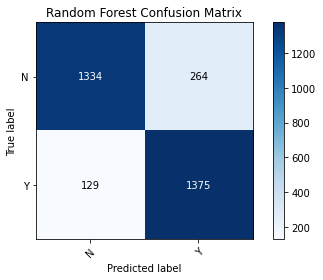

Training Naive Bayes Model


 93%|█████████▎| 14/15 [00:06<00:00,  3.78it/s]

----------------------------------------
----------------------------------------
----------------------------------------
----------------------------------------
----------------------------------------
----------------------------------------
----------------------------------------
----------------------------------------
----------------------------------------
----------------------------------------
----------------------------------------
----------------------------------------
----------------------------------------
----------------------------------------


100%|██████████| 15/15 [00:06<00:00,  2.43it/s]


----------------------------------------
Naive Bayes Model Results
----------------------------------------
Accuracy Score : 0.7998065764023211
Precision Score : 0.7101380295097572
Recall Score : 0.9920212765957447
F1 Score : 0.827739251040222
Confusion Matrix : 
[[ 989  609]
 [  12 1492]]


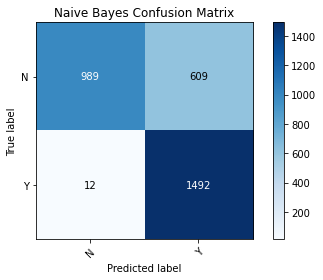

(GaussianNB(),
        rating  reviewUsefulCount  friendCount  reviewCount  firstCount  \
 1713        5                  1           12           19           0   
 5337        3                  0           53          478          52   
 10265       4                  0           15           21           0   
 2487        5                  0           12            8           0   
 11865       5                  0            5            7           0   
 ...       ...                ...          ...          ...         ...   
 12326       3                  0            0           14           3   
 7645        4                  0            0           14           1   
 10753       5                  0            0            2           0   
 2816        4                  0            2           21           1   
 10240       5                  0            0           23           0   
 
        scaledReviewPerDay  reviewsLength  reviewsDeviation  \
 1713             0.

In [22]:
semi_supervised_learning(under_sampled_df, model=rf, threshold=0.7, iterations=15, algorithm='Random Forest')
semi_supervised_learning(under_sampled_df, model=nb, threshold=0.7, iterations=15, algorithm='Naive Bayes')

Training Random Forest Model


  7%|▋         | 1/15 [00:42<09:57, 42.65s/it]

----------------------------------------


 13%|█▎        | 2/15 [00:55<05:26, 25.11s/it]

----------------------------------------


 20%|██        | 3/15 [01:07<03:50, 19.19s/it]

----------------------------------------


 27%|██▋       | 4/15 [01:19<02:59, 16.32s/it]

----------------------------------------


 33%|███▎      | 5/15 [01:31<02:27, 14.73s/it]

----------------------------------------


 40%|████      | 6/15 [01:43<02:04, 13.88s/it]

----------------------------------------


 47%|████▋     | 7/15 [01:55<01:45, 13.20s/it]

----------------------------------------


 53%|█████▎    | 8/15 [02:07<01:29, 12.74s/it]

----------------------------------------


 60%|██████    | 9/15 [02:18<01:14, 12.42s/it]

----------------------------------------


 67%|██████▋   | 10/15 [02:30<01:00, 12.19s/it]

----------------------------------------


 73%|███████▎  | 11/15 [02:42<00:48, 12.06s/it]

----------------------------------------


 80%|████████  | 12/15 [02:54<00:35, 11.94s/it]

----------------------------------------


 87%|████████▋ | 13/15 [03:05<00:23, 11.77s/it]

----------------------------------------


 93%|█████████▎| 14/15 [03:16<00:11, 11.65s/it]

----------------------------------------


100%|██████████| 15/15 [03:28<00:00, 13.88s/it]

----------------------------------------


Random Forest Model Results
----------------------------------------
Accuracy Score : 0.9131398823869662
Precision Score : 0.8718260869565218
Recall Score : 0.9683214216727835
F1 Score : 0.9175436990939873
Confusion Matrix : 
[[4459  737]
 [ 164 5013]]


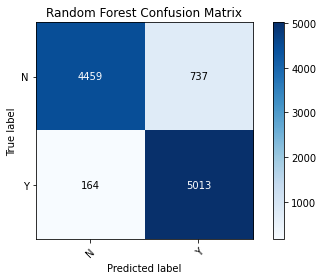

Training Naive Bayes Model


 13%|█▎        | 2/15 [00:36<03:14, 14.99s/it]

----------------------------------------
----------------------------------------
----------------------------------------


 40%|████      | 6/15 [00:36<00:26,  3.00s/it]

----------------------------------------
----------------------------------------
----------------------------------------
----------------------------------------


 80%|████████  | 12/15 [00:36<00:02,  1.28it/s]

----------------------------------------
----------------------------------------
----------------------------------------
----------------------------------------
----------------------------------------


100%|██████████| 15/15 [00:37<00:00,  2.47s/it]


----------------------------------------
----------------------------------------
----------------------------------------
Naive Bayes Model Results
----------------------------------------
Accuracy Score : 0.7928275330184131
Precision Score : 0.7109810479375697
Recall Score : 0.9855128452771875
F1 Score : 0.826034161742087
Confusion Matrix : 
[[3122 2074]
 [  75 5102]]


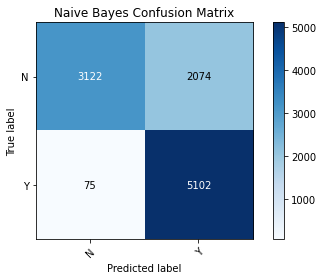

(GaussianNB(),
        rating  reviewUsefulCount  friendCount  reviewCount  firstCount  \
 30018       5                  0            0           14           1   
 24958       5                  0            0            8           0   
 33318       1                  0            0            1           0   
 19271       2                  0            3           37          10   
 22756       3                  0            1           15           0   
 ...       ...                ...          ...          ...         ...   
 19722       4                  1            6           15           2   
 6857        5                  0            0            4           0   
 35661       4                  0            0            5           0   
 25332       5                  0            0            6           0   
 11856       2                  4           20           11           1   
 
        scaledReviewPerDay  reviewsLength  reviewsDeviation  \
 30018            0.

In [23]:
model, results = semi_supervised_learning(over_sampled_df, model=rf, threshold=0.7, iterations=15, algorithm='Random Forest')
semi_supervised_learning(over_sampled_df, model=nb, threshold=0.7, iterations=15, algorithm='Naive Bayes')

In [24]:
results.to_csv('../Data/thai_results.csv', index=False)